### 栅格数据分析（城市土地利用分析）
globeland30数据获取及简介：https://www.webmap.cn/commres.do?method=globeIndex    
10: 农业用地；20:森林；30:草地；40:灌木；50:湿地；60:水体；70:苔原；80:人工地表；90：裸地



In [1]:
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import geopandas as gpd


In [2]:
path_landcover = 'data/data-section-5/N48_20_2010LC030/n48_20_2010lc030.tif'
path_chenggong = 'data/data-section-5/kunming_chenggong.gpkg'

In [3]:
raster_rio = rio.open(path_landcover)
raster = raster_rio.read()
raster.shape

(1, 18602, 20969)

In [4]:
np.unique(raster)

array([  0,  10,  20,  30,  40,  50,  60,  80, 255], dtype=uint8)

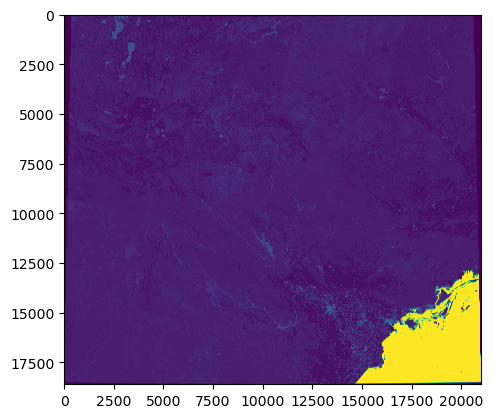

In [5]:
plt.imshow(raster[0])


In [6]:
chenggong_gpd = gpd.read_file(path_chenggong)
chenggong_gpd


,dt_adcode,dt_name,ct_adcode,ct_name,pr_adcode,pr_name,cn_adcode,cn_name,area,geometry
0,530114,chengong,530100,昆明市,530000,云南省,100000,中华人民共和国,499,"MULTIPOLYGON (((102.85321 24.69792, 102.85168 ..."


In [7]:
path_lc_chenggong = 'data/data-section-5/chenggong_landcover.tif'
## mask the region out of the shapefile extent.
!gdalwarp -cutline $path_chenggong -crop_to_cutline -overwrite $path_landcover $path_lc_chenggong


Copying color table from data/data-section-5/N48_20_2010LC030/n48_20_2010lc030.tif to new file.
Creating output file that is 998P x 1074L.
Processing data/data-section-5/N48_20_2010LC030/n48_20_2010lc030.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
chenggong_lc_rio = rio.open(path_lc_chenggong)
chenggong_lc = chenggong_lc_rio.read()
chenggong_lc.shape


(1, 1074, 998)

In [9]:
np.unique(chenggong_lc)

array([ 0, 10, 20, 30, 40, 60, 80], dtype=uint8)

Text(0.5, 1.0, 'globeland30 land cover')

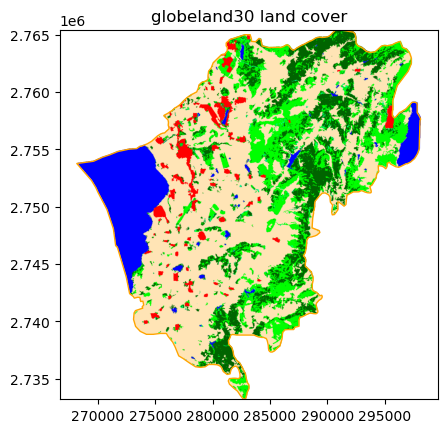

In [29]:
chenggong_building_color = np.full(shape = (chenggong_lc[0].shape[0], \
                                   chenggong_lc[0].shape[1], 3), fill_value=255)
color_list = {0: np.array([255,255,255]),       ##  
              10: np.array([255,228,181]),      ## 农业用地
              20: np.array([0,100,0]),      ## 森林
              30: np.array([0,255,0]),      ## 草地
              40: np.array([0,250,154]),      ## 灌木
              60: np.array([0,0,255]),      ## 水体
              80: np.array([255,0,0])}          ## 人造地表

for color_code in color_list.keys():
    chenggong_building_color[chenggong_lc[0]==color_code] = color_list[color_code]

fig, ax = plt.subplots()
show = ax.imshow(chenggong_building_color, extent=[chenggong_lc_rio.bounds.left, \
              chenggong_lc_rio.bounds.right, chenggong_lc_rio.bounds.bottom, chenggong_lc_rio.bounds.top])

chenggong_gpd.to_crs(32648).plot(ax=ax, facecolor='none', edgecolor='orange')
ax.set_title('globeland30 land cover')



提取特定类别地物（以人造地表为例）

In [27]:
chenggong_lc_rio.crs


CRS.from_epsg(32648)

Text(0.5, 1.0, 'building region')

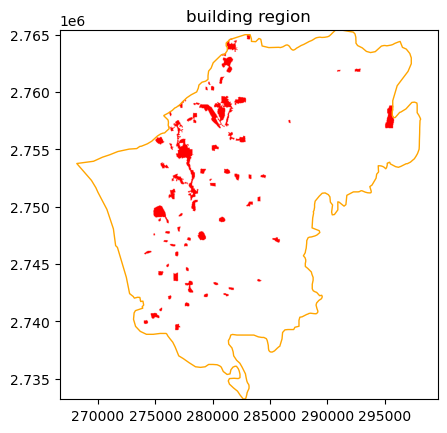

In [25]:
chenggong_building_color = np.full(shape = (chenggong_lc[0].shape[0], \
                                   chenggong_lc[0].shape[1], 3), fill_value=255)
color_list = {0: np.array([255,255,255]),         # non-building
              80: np.array([255,0,0])}       # building

for color_code in color_list.keys():
    chenggong_building_color[chenggong_lc[0]==color_code] = color_list[color_code]

fig, ax = plt.subplots()
show = ax.imshow(chenggong_building_color, extent=[chenggong_lc_rio.bounds.left, \
              chenggong_lc_rio.bounds.right, chenggong_lc_rio.bounds.bottom, chenggong_lc_rio.bounds.top])

chenggong_gpd.to_crs(32648).plot(ax=ax, facecolor='none', edgecolor='orange')
ax.set_title('building region')


不同地表覆盖类型面积统计分析

In [34]:
x_res, y_res = chenggong_lc_rio.res
area_pixel = (x_res*y_res)/(1000*1000)
area_pixel


0.0009

In [32]:
# ids_wat = np.where(chenggong_lc[0]==80)
# num_pixel = ids_wat[0].shape[0]
# area_wat = num_pixel*area_pixel
# print(area_wat)

## 设计为函数
def compute_area(dn=80):
  ids = np.where(chenggong_lc[0]==dn)
  num_pixel = ids[0].shape[0]
  area = num_pixel*area_pixel
  print(area)
  return area
  

In [35]:
dict_area = {}
dict_area['cultivated'] = compute_area(dn=10)
dict_area['forest'] = compute_area(dn=20)
dict_area['grassland'] = compute_area(dn=30)
dict_area['shrubland'] = compute_area(dn=40)
dict_area['water'] = compute_area(dn=60)
dict_area['building'] = compute_area(dn=80)
dict_area


249.28199999999998
81.5715
91.17
5.0472
54.1665
18.0936


{'cultivated': 249.28199999999998,
 'forest': 81.5715,
 'grassland': 91.17,
 'shrubland': 5.0472,
 'water': 54.1665,
 'building': 18.0936}

<BarContainer object of 6 artists>

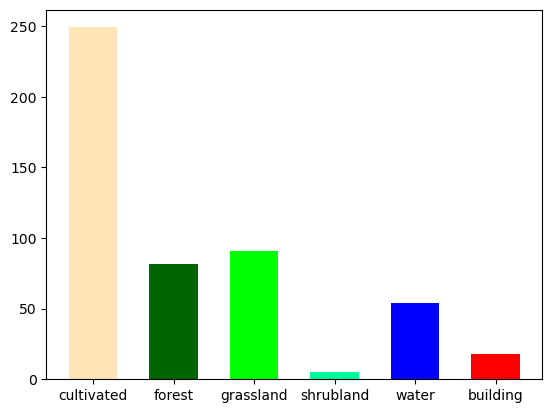

In [38]:
bar_colors = ['moccasin', "darkgreen",  'lime', 'mediumspringgreen', 'Blue', "red"]
# plt.bar(x=dict_area.keys(), height=dict_area.values(), width=0.6, color='green')
plt.bar(x=dict_area.keys(), height=dict_area.values(), width=0.6, color=bar_colors)


饼状图   
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html

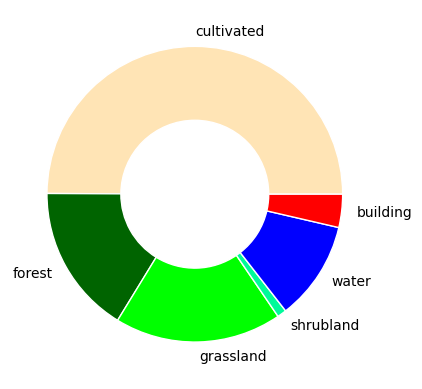

In [39]:
# plt.pie(x=dict_area.values(), labels=dict_area.keys(), colors=bar_colors);
plt.pie(x=dict_area.values(), radius=1, labels=dict_area.keys(), 
        colors=bar_colors, wedgeprops=dict(width=0.5, edgecolor='white'));

